# Data analysis notebook
This helps analyze any results recieved from the YIPPEE csv output.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd
import os
import haversine
import folium

In [ ]:
# DATA IMPORT
# Relative path to the data directory
from IPython import extract_module_locals

this_dir, this_filename = os.path.split("/".join(
    extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
) )
# Navigate 1 folders up, then into mem_dumps/
os.chdir(os.path.join(this_dir, '..', '..', 'mem_dumps'))

# DATA FILES MUST BE ENTERED IN (TITLE, FILENAME) FORMAT (Files are retrieved from the mem_dumps folder).
# ALTERNATIVELY, YOU CAN DIRECTLY ENTER A PANDAS DATAFRAME.
# ============ ENTER YOUR DATA FILES HERE ============
my_flight = ("ETEST DRIVE", "morgan.csv")

In [67]:
# UTILITIES
# ============ DO NOT EDIT BELOW THIS LINE ============
def parse_file(dataframe_or_filename):
    if isinstance(dataframe_or_filename, pd.DataFrame):
        return dataframe_or_filename
    else:
        return pd.read_csv(dataframe_or_filename, sep=',', header=0, index_col=0)
    
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

In [98]:
# PLOTTING FUNCTIONS
# --------------------------------------------------------------------
def plot_alts_vs_time(flight, save_plot_folder=""):
    flight_title, flight_df = flight
    flight_df = parse_file(flight_df)

    # Create a new figure
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(flight_title, fontsize=16)
    ax.plot(flight_df['realtime'], flight_df['gps_altitude'], label='GPS Altitude', color='blue', linewidth=2)
    ax.plot(flight_df['realtime'], flight_df['baro_altitude'], label='Barometer Altitude', color='red', linewidth=2)
    ax.set_xlabel('Time since Launch Detect (s)', fontsize=14)
    ax.set_ylabel('Altitude (m)', fontsize=14)
    ax.set_title('Altitude vs Time', fontsize=16)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set the limits
    ax.set_xlim(flight_df['realtime'].min(), flight_df['realtime'].max())
    ax.set_ylim(0, flight_df[['gps_altitude', 'baro_altitude']].max().max() + 10)

    # Vertical line at launch detect, fainter
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    if(save_plot_folder != ""):
        plt.savefig(f"./{save_plot_folder}/{flight_title}_altitude_vs_time.png", dpi=300, bbox_inches='tight')

    plt.show()
    

def create_gps_map(flight, save_map_folder=""):
    flight_title, flight_df = flight
    flight_df = parse_file(flight_df)

    # Filter out invalid GPS points (lat or lon == 0)
    valid_points = flight_df[(flight_df['lat'] != 0) & (flight_df['lon'] != 0)]

    path = list(zip(valid_points['lat'], valid_points['lon']))

    # Ensure we have at least one valid point
    if not path:
        raise ValueError("No valid GPS data found in the CSV.")

    # Initialize folium map centered on first point
    m = folium.Map(location=path[0], zoom_start=15)

    # arrow icon
    kw = {"prefix": "fa", "color": "blue", "icon": "arrow-up"}
    icon = folium.Icon(**kw)

    # rocket icon
    kw = {"prefix": "fa", "color": "green", "icon": "rocket"}
    icon_rocket = folium.Icon(**kw)

    # finish line icon 
    kw = {"prefix": "fa", "color": "red", "icon": "flag-checkered"}
    icon_finish = folium.Icon(**kw)

    # Add the path as a polyline
    folium.PolyLine(path, color="blue", weight=3).add_to(m)

    # Optionally add markers for start and end
    folium.Marker(path[0], tooltip="Launch!", icon=icon_rocket).add_to(m)
    folium.Marker(path[-1], tooltip="Landing", icon=icon_finish).add_to(m)

    # Determine altitude at "launch" (When "realtime" transitions from negative to positive)
    launch_index = flight_df[flight_df['realtime'] >= 0].index[0]
    launch_altitude = flight_df['baro_altitude'][launch_index]
    

    # Add a marker for the apogee point
    apogee_index = flight_df['baro_altitude'].idxmax()
    apogee_point = (flight_df['lat'][apogee_index], flight_df['lon'][apogee_index])
    apogee_altitude = flight_df['baro_altitude'][apogee_index]

    folium.Marker(apogee_point, tooltip=f"Apogee: {apogee_altitude:.2f}m ASL<br>({(apogee_altitude-launch_altitude):.2f}m AGL)", icon=icon).add_to(m)

    # Add small circle markers at each point with hover tooltip
    for _, row in valid_points.iterrows():
        tooltip_text = f"Time: {row['realtime']:.2f}<br>GPS Alt: {row['gps_altitude']:.2f} m<br>Baro Alt: {row['baro_altitude']:.2f}m<br>({(apogee_altitude-launch_altitude):.2f}m AGL)"
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=3,
            color='black',
            fill=True,
            fill_opacity=0.6,
            tooltip=folium.Tooltip(tooltip_text, sticky=True)
        ).add_to(m)

    

    # Save to HTML
    if save_map_folder != "":
        m.save(f"./{save_map_folder}/{flight_title}_gpsmap.html")
    else:
        m.save(f"{flight_title}_gpsmap.html")

def do_it_all(flight):
    flight_title, flight_df = flight
    flight_df = parse_file(flight_df)

    # Create a folder for the plots and maps
    create_folder(flight_title)

    # Plot altitude vs time
    plot_alts_vs_time(flight, save_plot_folder=flight_title)

    # Create GPS map
    create_gps_map(flight, save_map_folder=flight_title)

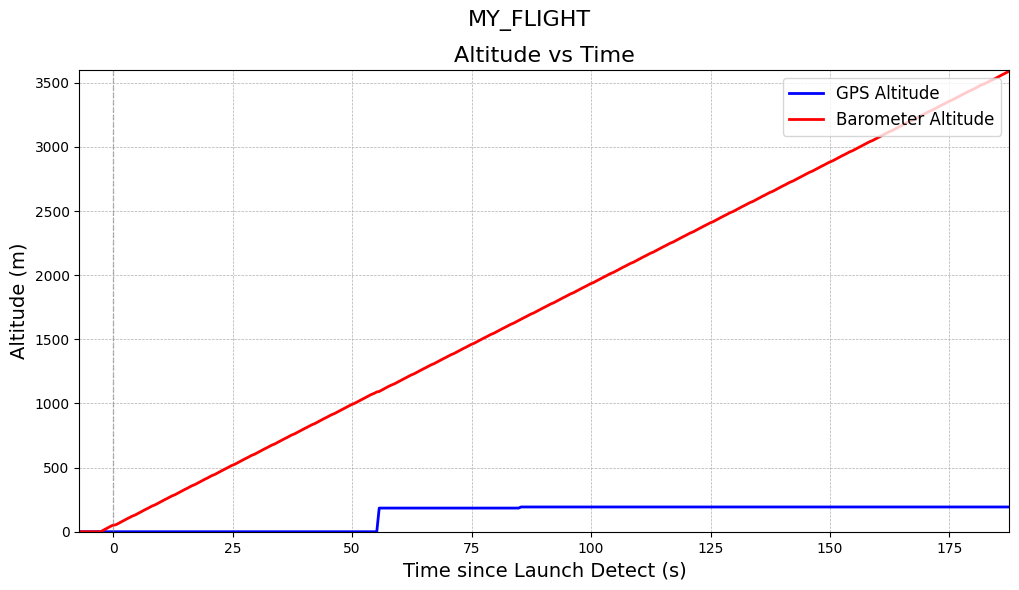

In [99]:
do_it_all(my_flight)